In [8]:
'''
Step1a. Fetch 225 constituent metadata & hist daily close px data
Filter out equities with MIN_AVG_VOLUME < 1m shares
'''
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import os
import time

text_tickers = """
4151 4502 4503 4506 4507 4519 4523 4568 4578 6479 6501 6503 6504 6506 6526 6594
6645 6674 6701 6702 6723 6724 6752 6753 6758 6762 6770 6841 6857 6861 6902 6920
6952 6954 6971 6976 6981 7735 7751 7752 8035 7201 7202 7203 7205 7211 7261 7267
7269 7270 7272 4543 4902 6146 7731 7733 7741 7762 4151 9432 9433 9434 9613 9984
5831 7186 8304 8306 8308 8309 8316 8331 8354 8411 8253 8591 8697 8601 8604 8630
8725 8750 8766 8795 1605 3401 3402 3405 3407 4004 4005 4021 4042 4043 4061 4063
4183 4188 4208 3861 3407 4452 4901 4911 6988 5101 5108 5201 5214 5233 5301 5332
5333 5401 5406 5411 3436 5706 5711 5713 5714 5801 5802 5803 2768 8001 8002 8015
8031 8053 8058 1721 1801 1802 1803 1808 1812 1925 1928 1963 5631 6103 6113 6273
6301 6302 6305 6326 6361 6367 6471 6472 6473 7004 7011 7012 7013 7832 7911 7912
7951 3289 8801 8802 8804 8830 9001 9005 9007 9008 9009 9020 9021 9022 9064 9147
9101 9104 9107 9201 9202 9501 9502 9503 9531 9532 1332 2002 2269 2282 2501 2502
2503 2801 2802 2871 2914 3086 3092 3099 3382 7453 8233 8252 8267 9843 9983 2413
2432 3659 4307 4324 4385 4661 4689 4704 4751 4755 6098 6178 6532 7974 9602 9735
9766
"""

# Convert to clean list of tickers (format: XXXX.T)
TICKERS = [f"{ticker}.T" for ticker in text_tickers.split()]

START_DATE = "2023-01-01"
END_DATE = "2025-06-01"
MIN_AVG_VOLUME = 1e6               # 1 million shares
CHECKPOINT_FILE = "N225_checkpoint.pkl"
OUTPUT_FILE = "N225_combined_data.csv"

def fetch_with_retry(ticker, max_retries=3):
    """Fetch data with retries to handle YF flakiness"""
    for _ in range(max_retries):
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=START_DATE, end=END_DATE)
            info = stock.info
            return hist, info
        except Exception as e:
            print(f"Retry {_+1}/{max_retries} for {ticker} | Error: {str(e)}")
            time.sleep(2)
    return None, None

def load_checkpoint():
    """Load progress if interrupted"""
    if os.path.exists(CHECKPOINT_FILE):
        return pd.read_pickle(CHECKPOINT_FILE)
    return pd.DataFrame()

def process_tickers():
    master_data = []
    checkpoint = load_checkpoint()
    processed_tickers = set(checkpoint.index.get_level_values(0)) if not checkpoint.empty else set()
    
    for ticker in tqdm([t for t in TICKERS if t not in processed_tickers], 
                       desc="Downloading Nikkei 225 Stocks"):
        hist, info = fetch_with_retry(ticker)
        
        if hist is not None and not hist.empty:
            # Calc AvgVolume: Mean of daily volumes over the period
            avg_volume = hist['Volume'].mean()
            
            if avg_volume >= MIN_AVG_VOLUME:
                row = {
                    'Ticker': ticker,
                    'Name': info.get('shortName', ticker),
                    'Sector': info.get('sector', 'N/A'),
                    'Industry': info.get('industry', 'N/A'),  # Added Industry
                    'AvgVolume': avg_volume,
                    'P/E': info.get('trailingPE', None),
                    'MarketCap': info.get('marketCap', None),
                    **{f"Close_{d.date()}": p for d, p in hist['Close'].items()}}
                master_data.append(row)
                
                # Save checkpoint every 5 tickers
                if len(master_data) % 5 == 0:
                    new_data = pd.DataFrame(master_data).set_index(['Ticker', 'Name'])
                    combined = pd.concat([checkpoint, new_data])
                    combined.to_pickle(CHECKPOINT_FILE)
    
    # Combine all data
    new_data = pd.DataFrame(master_data).set_index(['Ticker', 'Name'])
    final_df = pd.concat([checkpoint, new_data])
    
    # Cleanup checkpoint
    if os.path.exists(CHECKPOINT_FILE):
        os.remove(CHECKPOINT_FILE)
    
    return final_df.T  

if __name__ == "__main__":
    try:
        df = process_tickers()
        df.to_csv(OUTPUT_FILE)
        print(f"\nData saved to {OUTPUT_FILE}")
        print("\nSample Output:")
        print(df.iloc[:5, :5])
        
        # Show sector/industry stats
        print("\nSector Distribution:")
        print(df.loc['Sector'].value_counts())
        print("\nIndustry Distribution:")
        print(df.loc['Industry'].value_counts())
        
    except KeyboardInterrupt:
        print("\nProcess interrupted. Run again to resume.")



Data saved to N225_combined_data.csv

Sample Output:
Ticker                           4151.T  \
Name                 KYOWA KIRIN CO LTD   
Sector                       Healthcare   
Industry   Drug Manufacturers - General   
AvgVolume                1131355.348048   
P/E                           24.188595   
MarketCap                 1236459192320   

Ticker                                       4502.T  \
Name                   TAKEDA PHARMACEUTICAL CO LTD   
Sector                                   Healthcare   
Industry   Drug Manufacturers - Specialty & Generic   
AvgVolume                            4251241.765705   
P/E                                         63.5364   
MarketCap                             6678427729920   

Ticker                           4503.T  \
Name                    ASTELLAS PHARMA   
Sector                       Healthcare   
Industry   Drug Manufacturers - General   
AvgVolume                6739087.945671   
P/E                            50.35348   


In [2]:
'''
Step1b. Create DFs
'''
import pandas as pd

def load_n225_data(file_path):
    """Load N225 data from CSV with proper structure handling"""
    # Read CSV without assuming headers
    df = pd.read_csv(file_path, header=None)
    
    # Extract tickers from 1st row (B1, C1,...)
    tickers = df.iloc[0, 1:].tolist()
    
    # Extract metadata labels from column A (A2-A7)
    metadata_labels = df.iloc[1:7, 0].tolist()
    
    # Create metadata DF (tickers as index, labels as columns)
    metadata_df = pd.DataFrame(
        df.iloc[1:7, 1:].values.T,  # Transpose to get tickers as rows
        columns=metadata_labels,
        index=tickers)
    metadata_df.index.name = 'Ticker'
    
    # Convert numeric metadata fields
    numeric_fields = ['AvgVolume', 'P/E', 'MarketCap']
    for field in numeric_fields:
        if field in metadata_df.columns:
            metadata_df[field] = pd.to_numeric(metadata_df[field], errors='coerce')
    
    # Extract price data (rows 8+)
    prices = df.iloc[7:, 1:]
    
    # Extract/parse dates from column A (format: "Close_YYYY-MM-DD")
    date_str = df.iloc[7:, 0].str.replace('Close_', '')
    prices.index = pd.to_datetime(date_str)
    
    # Convert prices to numeric and set column names
    prices = prices.astype(float)
    prices.columns = tickers
    
    return metadata_df, prices

# Example usage
if __name__ == "__main__":
    metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
    
    print("=== METADATA (First 3 tickers) ===")
    print(metadata_df.head(3))
    
    print("\n=== PRICE DATA (First & Last 3 days) ===")
    print(prices_df.head(3))
    print(prices_df.tail(3))
    print("\n=== DATA SHAPES ===")
    print(f"Metadata shape: {metadata_df.shape}")
    print(f"Prices shape: {prices_df.shape}")

=== METADATA (First 3 tickers) ===
                                Name      Sector  \
Ticker                                             
4151.T            KYOWA KIRIN CO LTD  Healthcare   
4502.T  TAKEDA PHARMACEUTICAL CO LTD  Healthcare   
4503.T               ASTELLAS PHARMA  Healthcare   

                                        Industry     AvgVolume        P/E  \
Ticker                                                                      
4151.T              Drug Manufacturers - General  1.131355e+06  24.188595   
4502.T  Drug Manufacturers - Specialty & Generic  4.251242e+06  63.536400   
4503.T              Drug Manufacturers - General  6.739088e+06  50.353480   

            MarketCap  
Ticker                 
4151.T  1236459192320  
4502.T  6678427729920  
4503.T  2550025945088  

=== PRICE DATA (First & Last 3 days) ===
                 4151.T       4502.T       4503.T      4506.T       4507.T  \
0                                                                            


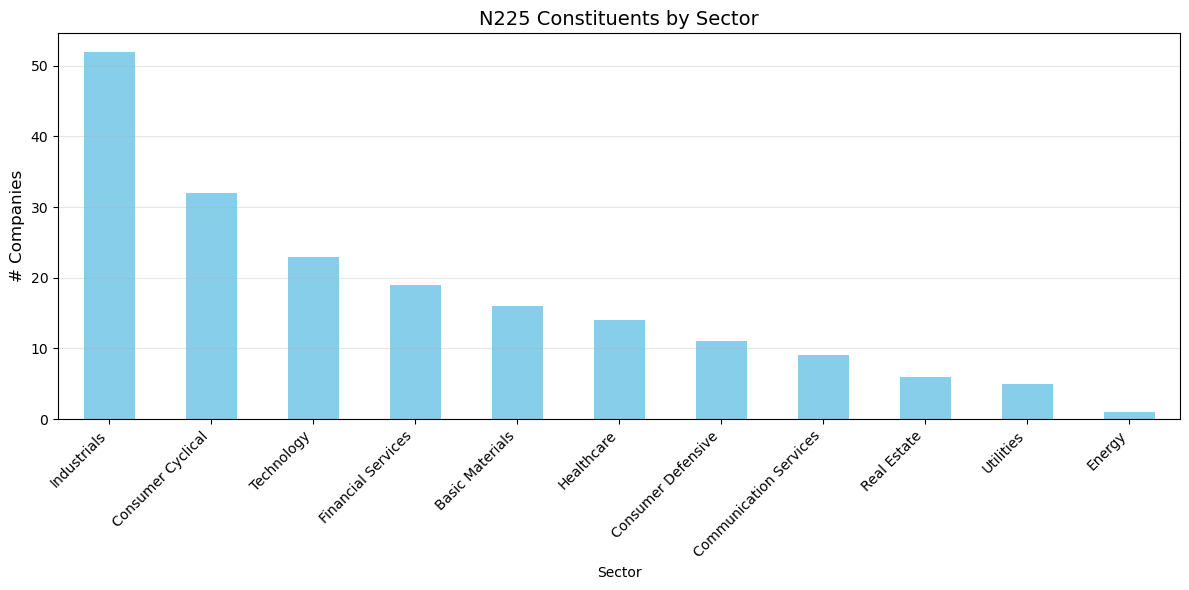

/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/33393203.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metadata, x='Sector', y='MarketCap', palette='viridis', showfliers=False)


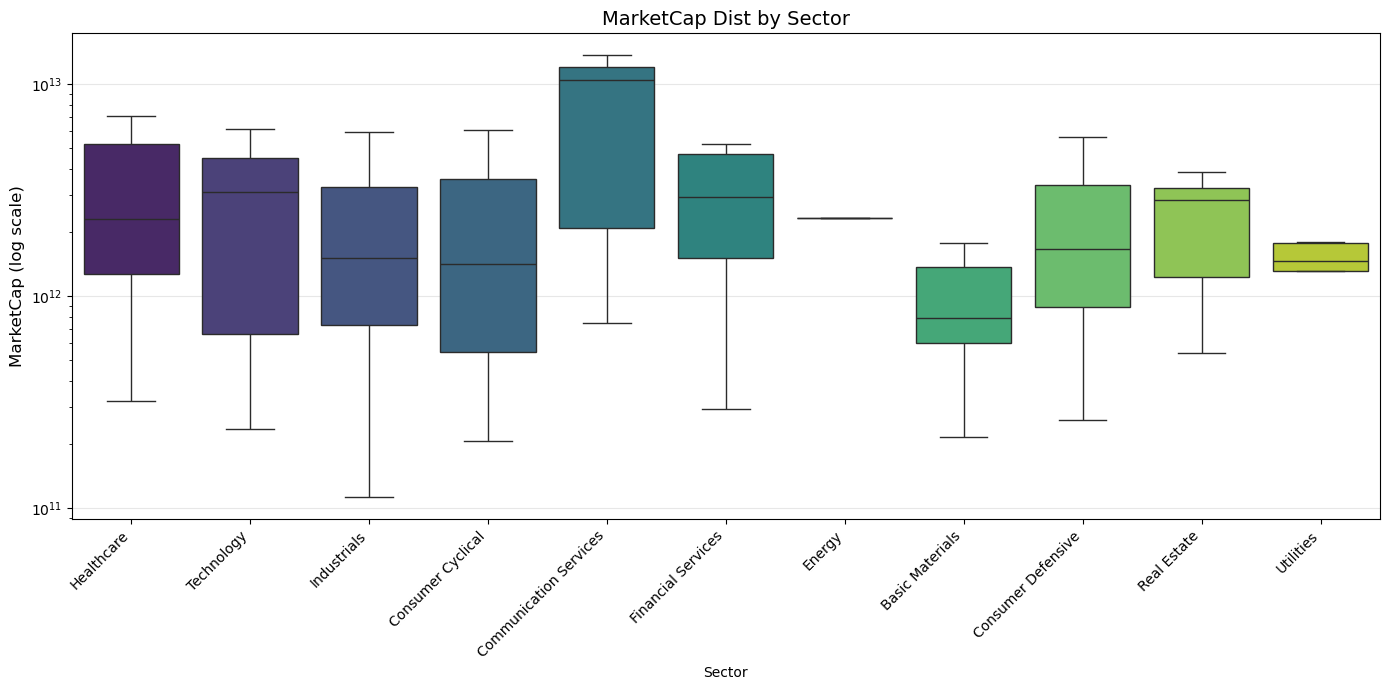

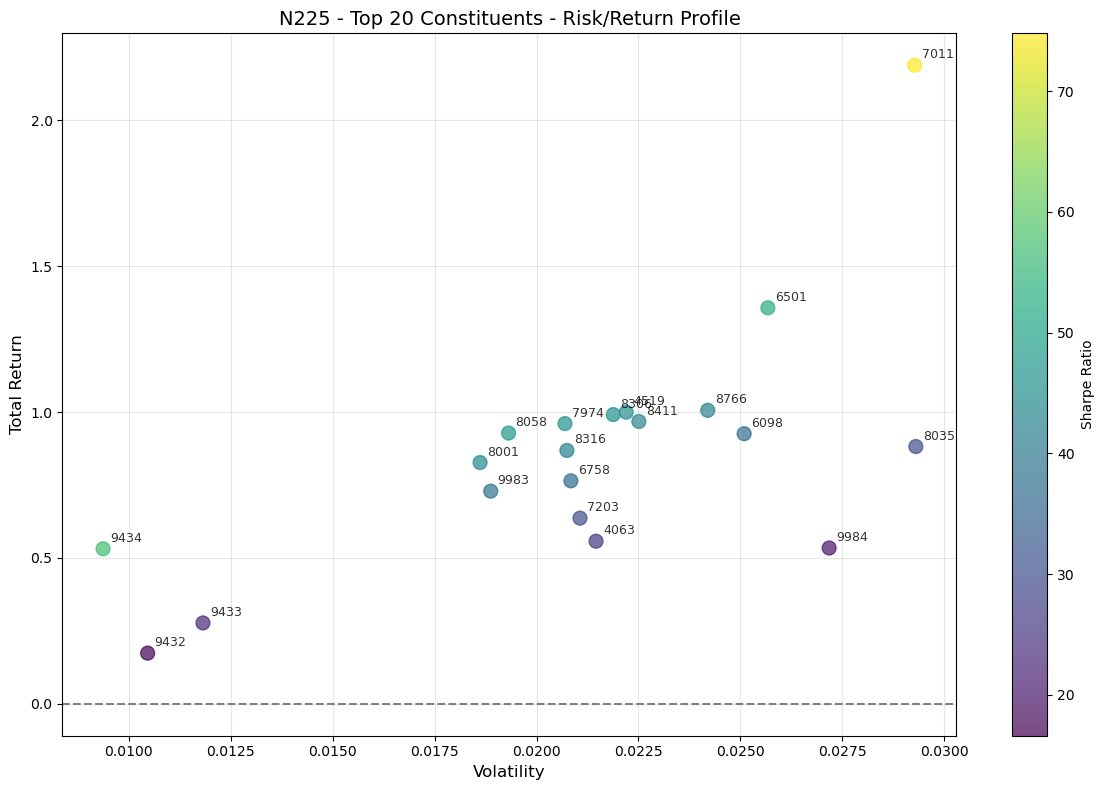

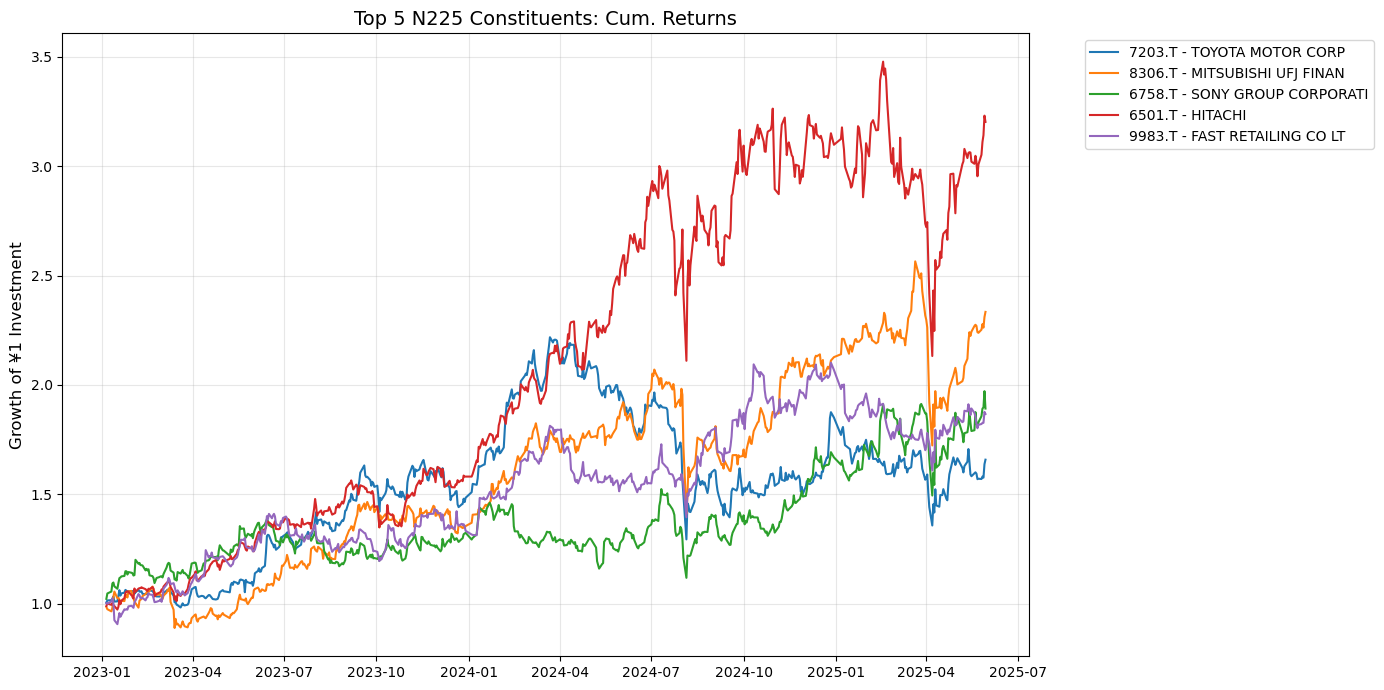

Top N225 Performers by Sharpe Ratio:
                               Name                  Sector  TotalReturn  Volatility  SharpeRatio
Ticker                                                                                           
7011.T  MITSUBISHI HEAVY INDUSTRIES             Industrials     2.189125    0.029273    74.783172
6701.T                     NEC CORP              Technology     1.602719    0.023503    68.191399
5803.T                     FUJIKURA             Industrials     2.401227    0.036651    65.516711
7453.T            RYOHIN KEIKAKU CO       Consumer Cyclical     1.465530    0.023729    61.760358
9434.T               SOFTBANK CORP.  Communication Services     0.531561    0.009364    56.766836
7013.T              IHI CORPORATION             Industrials     1.652397    0.029983    55.111205
1812.T                  KAJIMA CORP             Industrials     1.060395    0.019373    54.735154
5406.T                   KOBE STEEL         Basic Materials     1.214797    0.022

In [3]:
'''
Step1c. Prelim Charts
analysis_df: 
Ready for further analysis in subsequent code blocks, 
Contains both fundamental data (P/E, Market Cap) & calc'd technical metrics (returns, volatility).
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metadata = metadata_df.copy()
price_data = prices_df.copy()

if 'FirstPriceDate' not in metadata.columns:
    metadata['FirstPriceDate'] = price_data.apply(lambda x: x.first_valid_index())

# Chart1. Sector Dist
plt.figure(figsize=(12, 6))
sector_counts = metadata['Sector'].value_counts()
sector_counts.plot(kind='bar', color='skyblue')
plt.title('N225 Constituents by Sector', fontsize=14)
plt.ylabel('# Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Chart2. MarketCap Dist
plt.figure(figsize=(14, 7))
sns.boxplot(data=metadata, x='Sector', y='MarketCap', palette='viridis', showfliers=False)
plt.title('MarketCap Dist by Sector', fontsize=14)
plt.ylabel('MarketCap (log scale)', fontsize=12)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Chart3. Risk-Return Profile
def calculate_performance_metrics(price_data):
    returns = price_data.pct_change()
    total_returns = returns.sum()
    volatility = returns.std()
    sharpe_ratio = total_returns / volatility.replace(0, np.nan)
    return pd.DataFrame({'TotalReturn': total_returns,'Volatility': volatility,'SharpeRatio': sharpe_ratio})

performance_df = calculate_performance_metrics(price_data)
analysis_df = metadata.join(performance_df)
top_20 = analysis_df.nlargest(20, 'MarketCap')
plt.figure(figsize=(12, 8))
plt.scatter(top_20['Volatility'],  top_20['TotalReturn'], s=100,  alpha=0.7, c=top_20['SharpeRatio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')

for i, row in top_20.iterrows():
    plt.annotate(
        i.split('.')[0],                                    # Show just ticker (eg. "4151")
        (row['Volatility'], row['TotalReturn']), fontsize=9, alpha=0.8,  xytext=(5,5), textcoords='offset points')

plt.title('N225 - Top 20 Constituents - Risk/Return Profile', fontsize=14)
plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Total Return', fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Chart4. Cum. Returns
top_5_tickers = analysis_df.nlargest(5, 'MarketCap').index
cum_returns = (1 + price_data[top_5_tickers].pct_change()).cumprod()

plt.figure(figsize=(14, 7))
for ticker in top_5_tickers:
    plt.plot(cum_returns.index, cum_returns[ticker], label=f"{ticker} - {metadata.loc[ticker, 'Name'][:20]}")
plt.title('Top 5 N225 Constituents: Cum. Returns', fontsize=14)
plt.ylabel('Growth of ¥1 Investment', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display results
print("Top N225 Performers by Sharpe Ratio:")
print(analysis_df.nlargest(10, 'SharpeRatio')[['Name', 'Sector', 'TotalReturn', 'Volatility', 'SharpeRatio']].to_string())

print("\nWorst N225 Performers by Sharpe Ratio:")
print(analysis_df.nsmallest(10, 'SharpeRatio')[['Name', 'Sector', 'TotalReturn', 'Volatility', 'SharpeRatio']].to_string())

/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/1997965951.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['Return'] = portfolio['Value'].pct_change()
/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/1997965951.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['Return'] = portfolio['Value'].pct_change()
/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/1997965951.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a

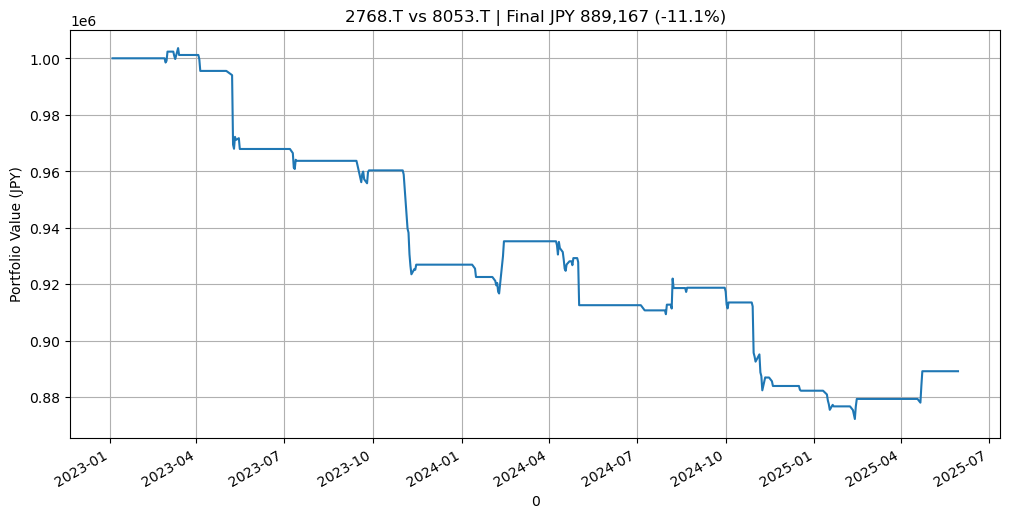

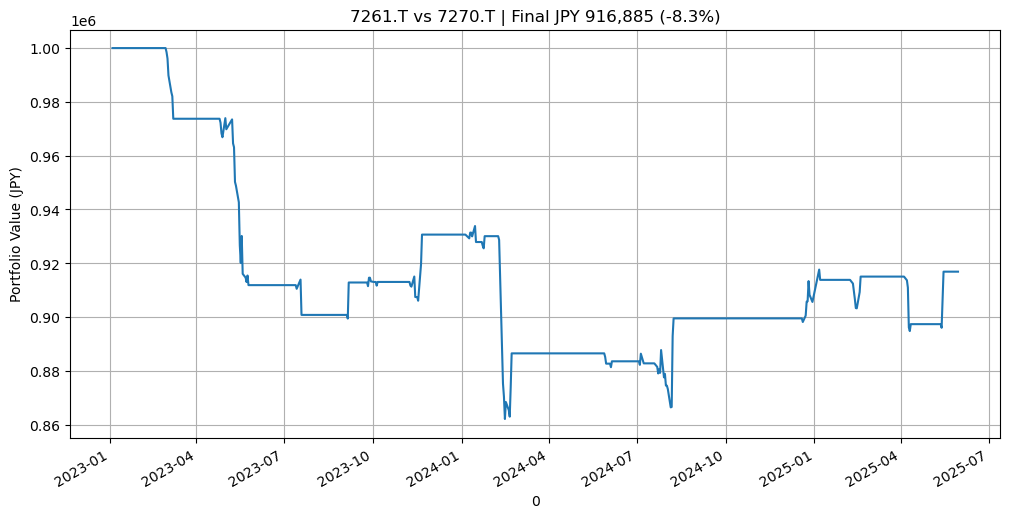

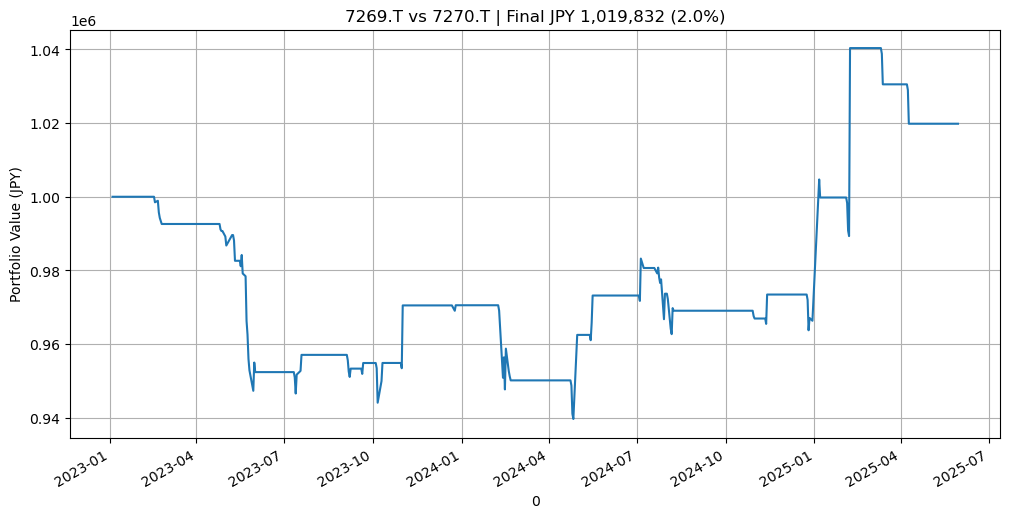

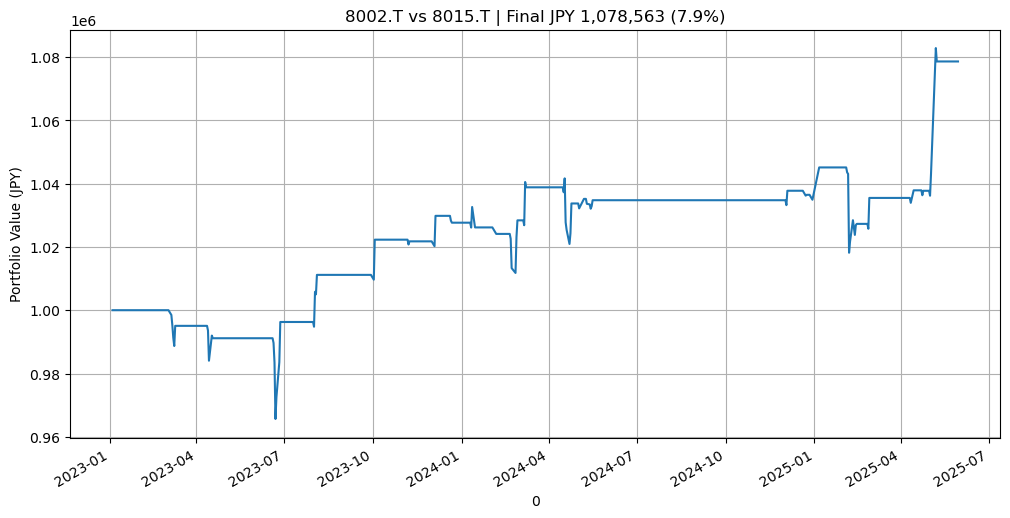

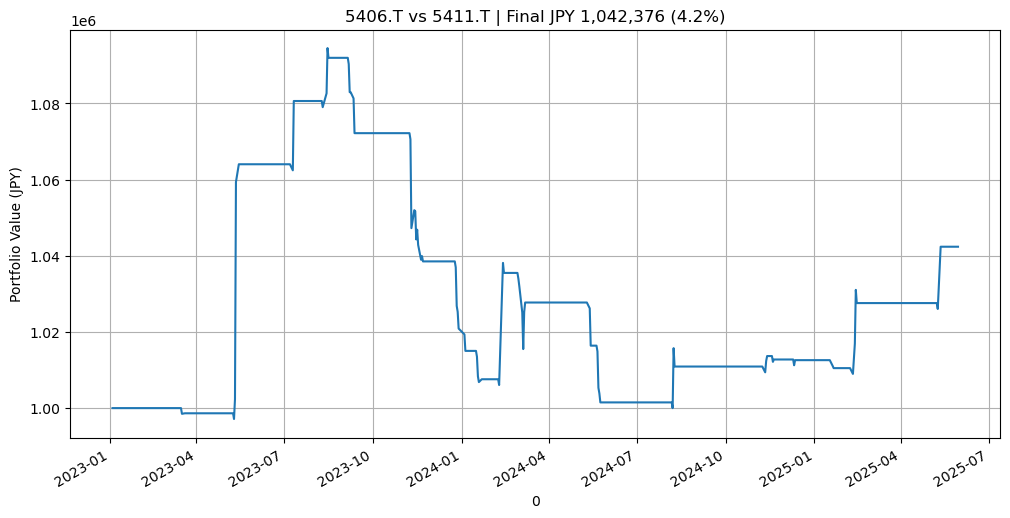

/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/1997965951.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df[['Total_Return', 'Ann_Return']] = formatted_df[['Total_Return', 'Ann_Return']].applymap(lambda x: f"{x:.2%}")


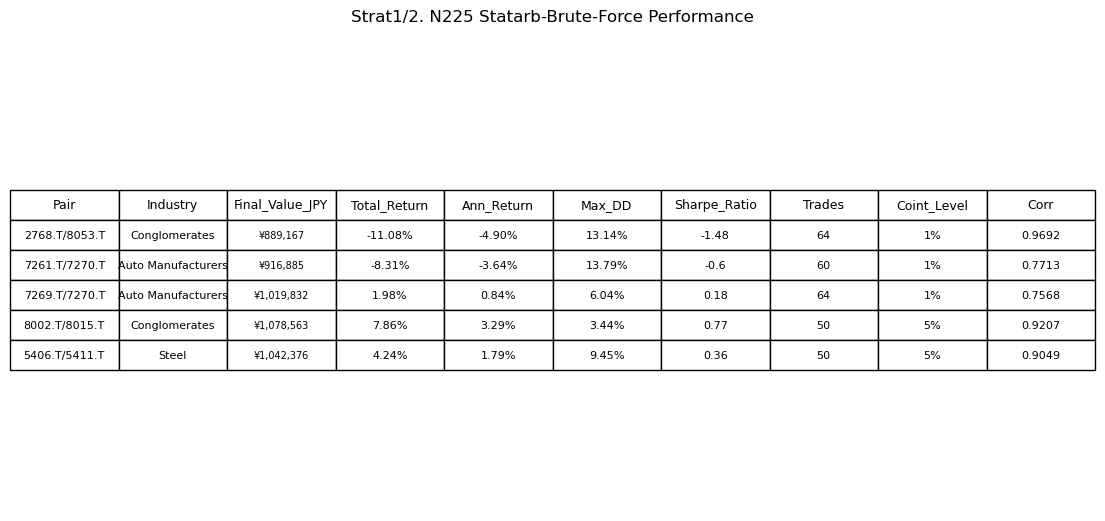


Strat1/2. N225 Statarb-BruteForce Performance:


,Pair,Industry,Final_Value_JPY,Total_Return,Ann_Return,Max_DD,Sharpe_Ratio,Trades
3,8002.T/8015.T,Conglomerates,1.078563e+06,0.078563,0.032887,0.034362,0.770763,50
4,5406.T/5411.T,Steel,1.042376e+06,0.042376,0.017915,0.094541,0.363630,50
2,7269.T/7270.T,Auto Manufacturers,1.019832e+06,0.019832,0.008437,0.060352,0.180616,64
1,7261.T/7270.T,Auto Manufacturers,9.168852e+05,-0.083115,-0.036445,0.137881,-0.597281,60
0,2768.T/8053.T,Conglomerates,8.891671e+05,-0.110833,-0.049017,0.131365,-1.479859,64



Total Invested: JPY 5,000,000
Total Final Value: JPY 4,946,823
Aggregate Return: -1.1%


In [6]:
'''
Step2a. Strat 1/2. N225 Statarb - Brute Force Method
Allocates JPY 100,000,000 per pair
Implements 50/50 capital allocation between legs
'''
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()]
industries = metadata_df['Industry'].to_dict()

# Generate pairs
industry_stocks = {}
for ticker, industry in industries.items():
    industry_stocks.setdefault(industry, []).append(ticker)
valid_industries = {k: v for k, v in industry_stocks.items() if len(v) >= 2}

# Cointegration testing
results = []
for industry, tickers in valid_industries.items():
    for ticker1, ticker2 in combinations(tickers, 2):
        try:
            price1 = prices_df[ticker1].iloc[-90:].dropna()
            price2 = prices_df[ticker2].iloc[-90:].dropna()
            common_dates = price1.index.intersection(price2.index)
            if len(common_dates) < 60:
                continue
                
            spread = price1[common_dates] - price2[common_dates]
            adf_result = adfuller(spread, autolag="AIC")
            test_stat, pvalue, _, _, critical_values, _ = adf_result
            corr, _ = pearsonr(price1[common_dates], price2[common_dates])
            
            coint_level = next((level for level, cv in critical_values.items() if test_stat < cv), None)
            
            results.append({'Industry': industry, 'Ticker1': ticker1, 'Name1': metadata_df.loc[ticker1, 'Name'],
                'Ticker2': ticker2, 'Name2': metadata_df.loc[ticker2, 'Name'],
                'ADF_Stat': test_stat, 'Cointegrated': coint_level, 'Corr': corr, 'DataPts': len(common_dates)})
        except:
            continue

results_df = pd.DataFrame(results)
results_df['Score'] = results_df.apply(lambda x: (3 if x['Cointegrated']=='1%' else 2 if x['Cointegrated']=='5%' else 1 if x['Cointegrated']=='10%' else 0) + abs(x['Corr'])*2, axis=1)
top_pairs = results_df.sort_values('Score', ascending=False).head(5)

# Strat1. N225 Statarb - Brute Force with JPY allocation
initial_capital = 1_000_000                             # JPY per pair
transaction_cost = 0.0015                               # 0.15% per trade
results = []
portfolios = []

for _, pair in top_pairs.iterrows():
    ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
    
    # Align prices
    price1 = prices_df[ticker1].dropna()
    price2 = prices_df[ticker2].dropna()
    common_idx = price1.index.intersection(price2.index)
    p1, p2 = price1[common_idx], price2[common_idx]
    
    # Calc spread & z-score
    spread = p1 - p2
    mean_spread = spread.rolling(30).mean()
    std_spread = spread.rolling(30).std()
    zscore = (spread - mean_spread) / std_spread
    
    # Generate signals
    signals = pd.Series(0, index=zscore.index)
    signals[zscore > 2.0] = -1                        # Short spread (buy T2, sell T1)
    signals[zscore < -2.0] = 1                        # Long spread
    signals[(zscore.abs() < 0.5)] = 0                 # Exit
    signals = signals.ffill().shift()                 # Trade on next day
    
    # Position sizing
    capital = initial_capital
    position1, position2 = 0, 0
    portfolio = pd.DataFrame(index=common_idx, columns=['Value', 'Return', 'Position1', 'Position2', 'Cum'])
    
    for date in common_idx[30:]:  # Skip warmup period
        current_signal = signals.loc[date]
        prev_signal = signals.shift(1).loc[date]
        
        # Execute trades
        if current_signal != prev_signal:
            # Close existing positions
            if prev_signal != 0:
                capital += position1 * p1.loc[date] * (1 - transaction_cost)
                capital += position2 * p2.loc[date] * (1 - transaction_cost)
                position1, position2 = 0, 0
            
            # Open new positions
            if current_signal == 1:  # Long spread
                position1 = (capital/2) / p1.loc[date]
                position2 = -(capital/2) / p2.loc[date]
                capital -= abs(position1 * p1.loc[date] * transaction_cost)
                capital -= abs(position2 * p2.loc[date] * transaction_cost)
            elif current_signal == -1:  # Short spread
                position1 = -(capital/2) / p1.loc[date]
                position2 = (capital/2) / p2.loc[date]
                capital -= abs(position1 * p1.loc[date] * transaction_cost)
                capital -= abs(position2 * p2.loc[date] * transaction_cost)
        
        # Daily valuation
        portfolio.loc[date, 'Value'] = capital + position1 * p1.loc[date] + position2 * p2.loc[date]
        portfolio.loc[date, ['Position1', 'Position2']] = position1, position2
    
    # Calc returns
    portfolio['Return'] = portfolio['Value'].pct_change()
    portfolio['Cumulative'] = (1 + portfolio['Return'].fillna(0)).cumprod() * initial_capital
    portfolios.append(portfolio)
    
    # Store results
    final_value = portfolio['Value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital
    max_drawdown = (portfolio['Value'].cummax() - portfolio['Value']).max() / initial_capital
    
    results.append({
        'Pair': f"{ticker1}/{ticker2}",
        'Industry': pair['Industry'],
        'Final_Value_JPY': final_value,
        'Total_Return': total_return,
        'Ann_Return': (1 + total_return)**(252/len(portfolio)) - 1,
        'Max_DD': max_drawdown,
        'Sharpe_Ratio': portfolio['Return'].mean() / portfolio['Return'].std() * np.sqrt(252),
        'Trades': (signals.diff() != 0).sum(),
        'Coint_Level': pair['Cointegrated'],
        'Corr': pair['Corr']})

# Generate visualizations
def generate_visualizations(results_df, portfolios, top_pairs):
    
    # 1. Indv pair performance charts
    for i, (_, pair) in enumerate(top_pairs.iterrows()):
        ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
        portfolio = portfolios[i]
        final_value = portfolio['Value'].iloc[-1]
        total_return = (final_value - initial_capital)/initial_capital
        
        plt.figure(figsize=(12, 6))
        portfolio['Cumulative'].plot(title=f"{ticker1} vs {ticker2} | Final JPY {final_value:,.0f} ({total_return:.1%})")
        plt.ylabel('Portfolio Value (JPY)')
        plt.grid(True)
        
        filename = f"Strat-Statarb-BruteForce_Pair_{ticker1}_vs_{ticker2}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
    
    # 2. Performance summary table
    display_cols = ['Pair', 'Industry', 'Final_Value_JPY', 'Total_Return', 'Ann_Return', 'Max_DD', 'Sharpe_Ratio', 'Trades', 'Coint_Level', 'Corr']
    fig, ax = plt.subplots(figsize=(14, 6))  
    ax.axis('off')
    ax.set_title("Strat1/2. N225 Statarb-Brute-Force Performance", pad=20, fontsize=12)
    
    # Create formatted values for display
    formatted_df = results_df[display_cols].copy()
    formatted_df['Final_Value_JPY'] = formatted_df['Final_Value_JPY'].apply(lambda x: f"¥{x:,.0f}")
    formatted_df[['Total_Return', 'Ann_Return']] = formatted_df[['Total_Return', 'Ann_Return']].applymap(lambda x: f"{x:.2%}")
    formatted_df['Max_DD'] = formatted_df['Max_DD'].apply(lambda x: f"{x:.2%}")
    formatted_df['Sharpe_Ratio'] = formatted_df['Sharpe_Ratio'].round(2)
    formatted_df['Corr'] = formatted_df['Corr'].round(4) 
    
    table = ax.table(cellText=formatted_df.values, colLabels=display_cols, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    
    # table.scale(1.2, 1.5)  
    industry_col_idx = display_cols.index('Industry') + 1  # +1 because row 0 is header
    for key, cell in table.get_celld().items():
        if key[0] == 0:  
            cell.set_fontsize(9)
        elif key[1] == industry_col_idx:  
            cell.set_fontsize(7) 
    table.scale(1, 1.8)
    
    plt.savefig("Strat1-Statarb-BruteForce_Summary.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Generate & save visualizations
results_df = pd.DataFrame(results)
generate_visualizations(results_df, portfolios, top_pairs)

# Print final summary with proper column selection
print("\nStrat1/2. N225 Statarb-BruteForce Performance:")
summary_cols = ['Pair', 'Industry', 'Final_Value_JPY', 'Total_Return', 'Ann_Return', 'Max_DD', 'Sharpe_Ratio', 'Trades']
display(results_df[summary_cols].sort_values('Total_Return', ascending=False))

# Calc & aggregate performance
total_invested = initial_capital * len(top_pairs)
total_final = results_df['Final_Value_JPY'].sum()
print(f"\nTotal Invested: JPY {total_invested:,.0f}")
print(f"Total Final Value: JPY {total_final:,.0f}")
print(f"Aggregate Return: {(total_final - total_invested)/total_invested:.1%}")

Determining optimal clusters...


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 41.14it/s]


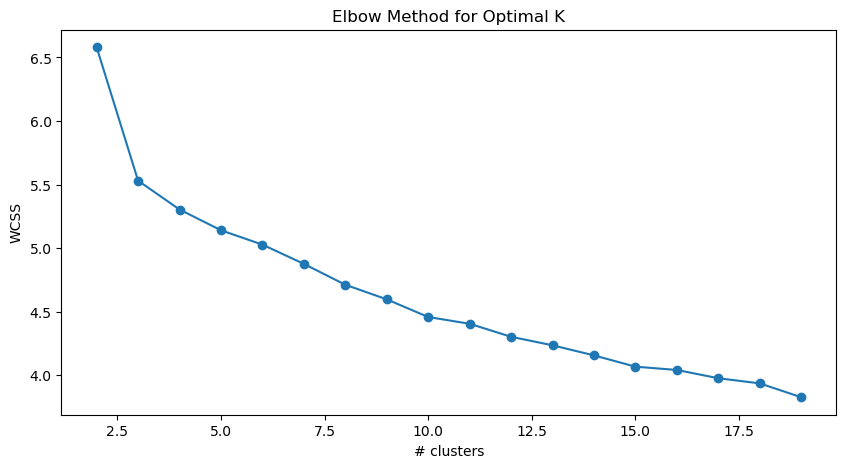


Finding cointegrated pairs within clusters...

Backtesting selected pairs...


/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/2427675183.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['Return'] = portfolio['Value'].pct_change()
/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/2427675183.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['Return'] = portfolio['Value'].pct_change()
/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/2427675183.py:157: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a

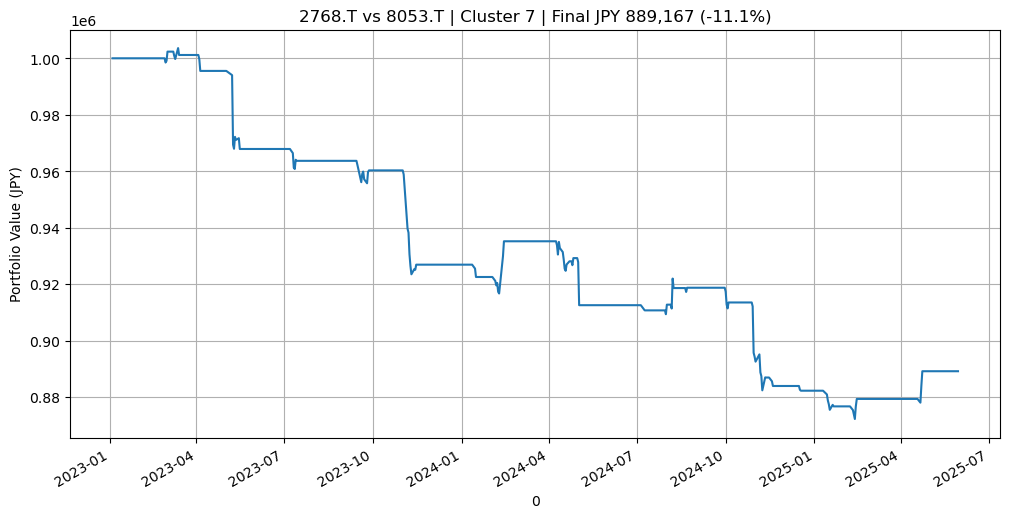

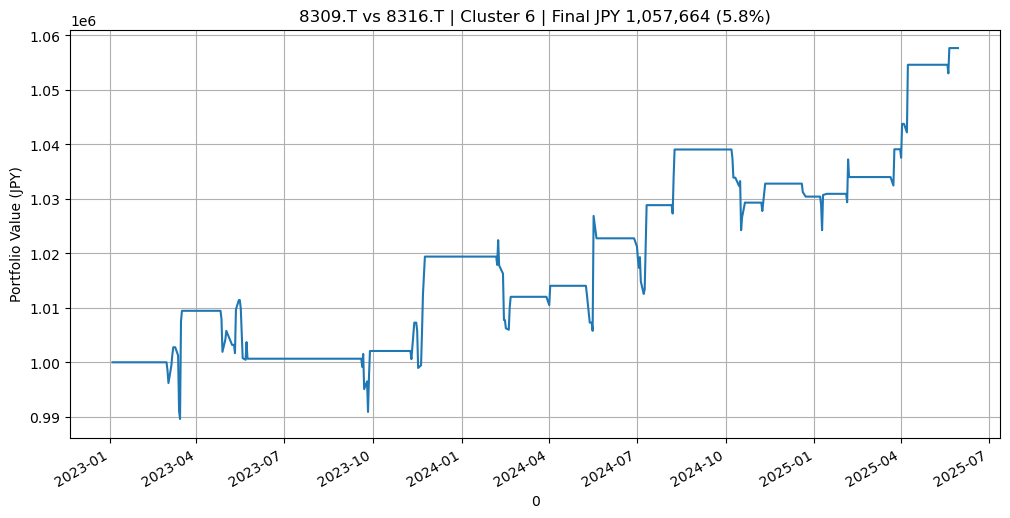

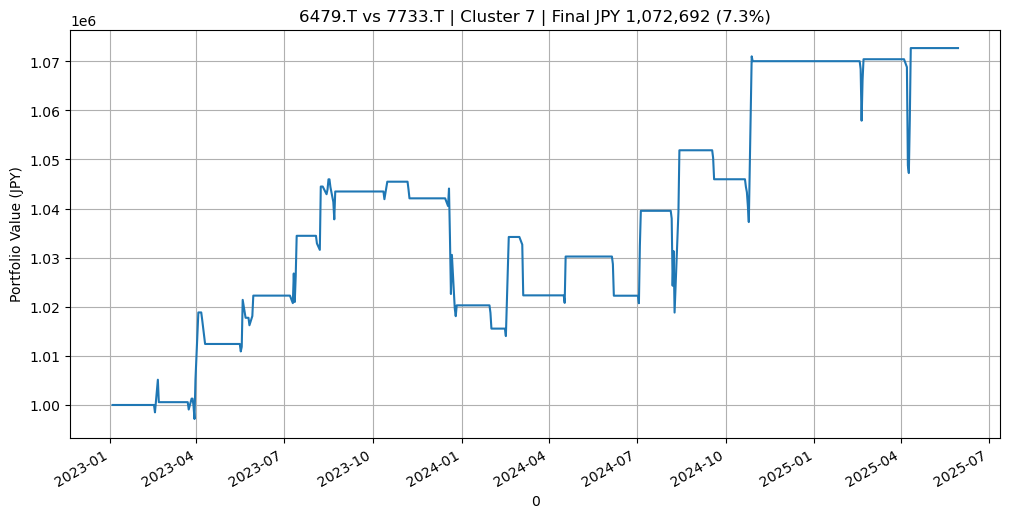

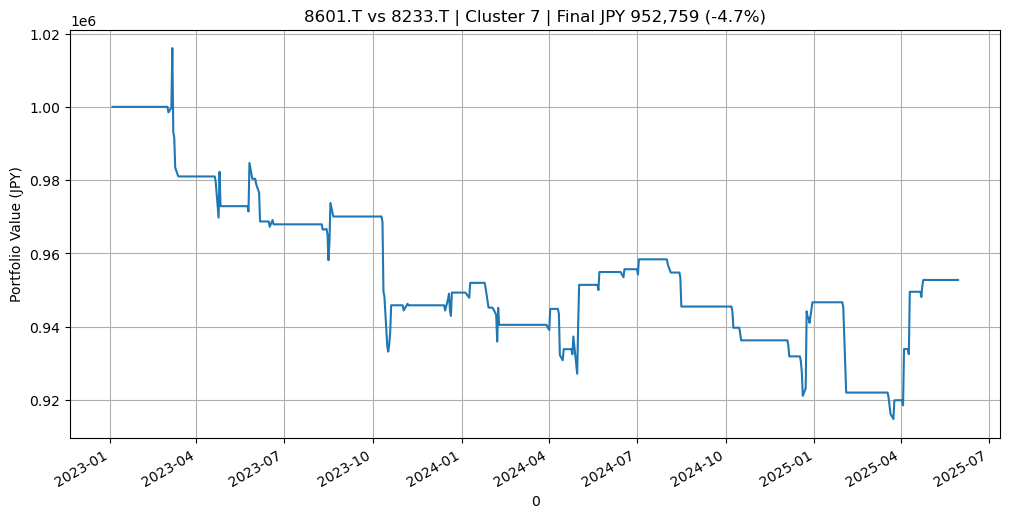

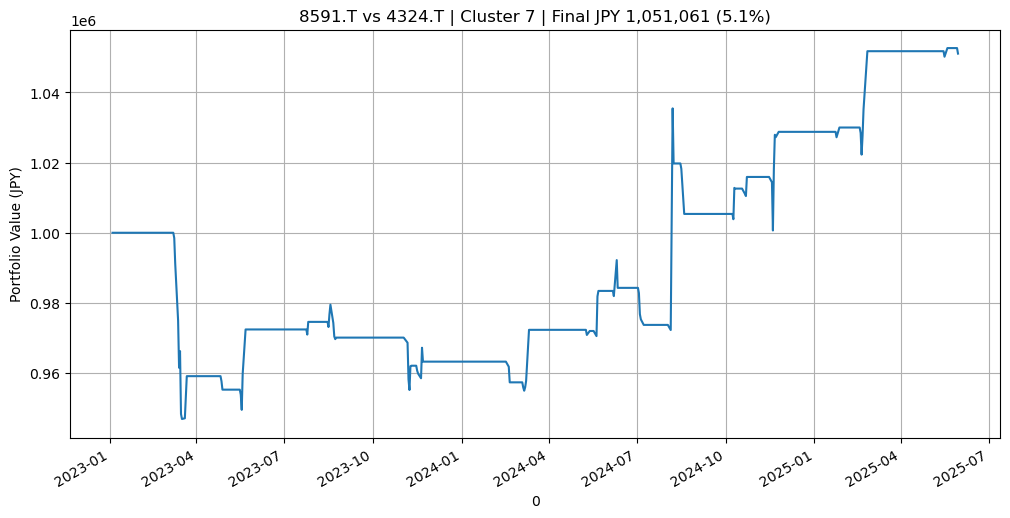

/var/folders/81/tfp9tldx3nq9004lhg26p4zc0000gn/T/ipykernel_18708/2427675183.py:226: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df[['Total_Return', 'Ann_Return']] = formatted_df[['Total_Return', 'Ann_Return']].applymap(lambda x: f"{x:.2%}")


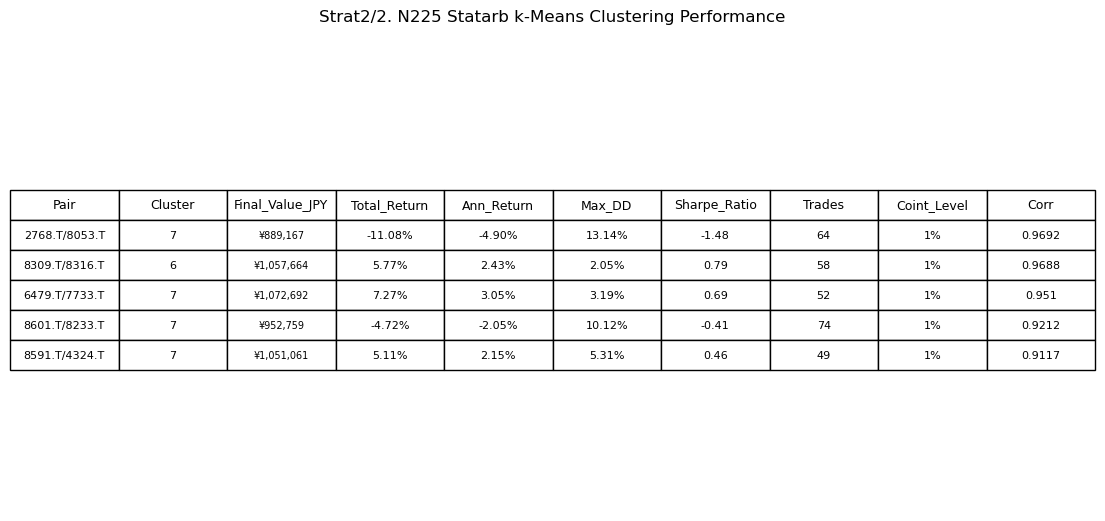


Strat2. N225-Statarb-K-Means Performance Summary:


,Pair,Cluster,Final_Value_JPY,Total_Return,Ann_Return,Max_DD,Sharpe_Ratio,Trades
2,6479.T/7733.T,7,1.072692e+06,0.072692,0.030477,0.031932,0.692473,52
1,8309.T/8316.T,6,1.057664e+06,0.057664,0.024276,0.020531,0.785601,58
4,8591.T/4324.T,7,1.051061e+06,0.051061,0.021535,0.053082,0.461104,49
3,8601.T/8233.T,7,9.527586e+05,-0.047241,-0.020492,0.101230,-0.412902,74
0,2768.T/8053.T,7,8.891671e+05,-0.110833,-0.049017,0.131365,-1.479859,64



Total Invested: JPY 5,000,000
Total Final Value: JPY 5,023,342
Aggregate Return: 0.5%


In [7]:
'''
Step2b. Strat2/2. N225 Statarb - k-Means Clustering
* uses return corrs & k-means clustering to group similar N225 constituent equities.
* selects pairs from within clusters rather than pre-defined industries
* elbow method helps determine optimal cluster count
* maintains identical backtesting params to Strat1/2 for fair comparison
* remaining logic (cointegration testing, trading signals, position sizing & performance metrics) 
  remains identical to the Strat1/2 above.
* k-means approach may discover non-intuitive pairs that behave similarly despite being from different industries, 
  potentially uncovering new opportunities that the industry-based approach might miss.
'''
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations

metadata_df, prices_df = load_n225_data("N225_combined_data.csv")
prices_df = prices_df.loc[:, ~prices_df.columns.duplicated()]

def kmeans_statarb_strategy(prices_df, metadata_df, initial_capital=1_000_000, transaction_cost=0.0015):
    # Prep price matrix for clustering (90d returns)
    returns_df = prices_df.pct_change().iloc[-90:].dropna(axis=1)
    tickers = returns_df.columns
    X = returns_df.T.values

    # Determine optimal clusters using Elbow Method
    print("Determining optimal clusters...")
    wcss = []
    for i in tqdm(range(2, 20)):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10,5))
    plt.plot(range(2, 20), wcss, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('# clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Based on elbow plot, select K=8 clusters
    optimal_k = 8
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(X)
    cluster_assignments = dict(zip(tickers, clusters))

    # Find intra-cluster pairs
    print("\nFinding cointegrated pairs within clusters...")
    results = []
    for cluster_id in range(optimal_k):
        cluster_tickers = [ticker for ticker, cluster in cluster_assignments.items() 
                          if cluster == cluster_id]
        
        if len(cluster_tickers) < 2:
            continue
            
        # Test all combos within cluster
        for ticker1, ticker2 in combinations(cluster_tickers, 2):
            try:
                price1 = prices_df[ticker1].iloc[-90:].dropna()
                price2 = prices_df[ticker2].iloc[-90:].dropna()
                common_dates = price1.index.intersection(price2.index)
                
                if len(common_dates) < 60:
                    continue
                    
                spread = price1[common_dates] - price2[common_dates]
                adf_result = adfuller(spread, autolag="AIC")
                test_stat, pvalue, _, _, critical_values, _ = adf_result
                corr, _ = pearsonr(price1[common_dates], price2[common_dates])
                
                coint_level = next((level for level, cv in critical_values.items() 
                                  if test_stat < cv), None)
                
                results.append({
                    'Cluster': cluster_id, 
                    'Ticker1': ticker1,  'Name1': metadata_df.loc[ticker1, 'Name'],
                    'Ticker2': ticker2,  'Name2': metadata_df.loc[ticker2, 'Name'],
                    'ADF_Stat': test_stat,  'Cointegrated': coint_level,
                    'Corr': corr,  'DataPts': len(common_dates)})
            except:
                continue

    # Score & select top pairs 
    results_df = pd.DataFrame(results)
    results_df['Score'] = results_df.apply(
        lambda x: (3 if x['Cointegrated']=='1%' else 
                  2 if x['Cointegrated']=='5%' else 
                  1 if x['Cointegrated']=='10%' else 0) + abs(x['Corr'])*2, axis=1)
    top_pairs = results_df.sort_values('Score', ascending=False).head(5)
    
    # Backtesting
    print("\nBacktesting selected pairs...")
    portfolios = []
    results = []

    for _, pair in top_pairs.iterrows():
        ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
        
        # Align prices
        price1 = prices_df[ticker1].dropna()
        price2 = prices_df[ticker2].dropna()
        common_idx = price1.index.intersection(price2.index)
        p1, p2 = price1[common_idx], price2[common_idx]
        
        # Calc spread & z-score
        spread = p1 - p2
        mean_spread = spread.rolling(30).mean()
        std_spread = spread.rolling(30).std()
        zscore = (spread - mean_spread) / std_spread
        
        # Generate signals
        signals = pd.Series(0, index=zscore.index)
        signals[zscore > 2.0] = -1                               # Short spread (buy T2, sell T1)
        signals[zscore < -2.0] = 1                               # Long spread
        signals[(zscore.abs() < 0.5)] = 0                        # Exit
        signals = signals.ffill().shift()                        # Trade on next day
        
        # Position sizing
        capital = initial_capital
        position1, position2 = 0, 0
        portfolio = pd.DataFrame(index=common_idx, columns=['Value', 'Return', 'Position1', 'Position2'])
        
        for date in common_idx[30:]:                              # Skip warmup period
            current_signal = signals.loc[date]
            prev_signal = signals.shift(1).loc[date]
            
            # Execute trades
            if current_signal != prev_signal:
                # Close existing positions
                if prev_signal != 0:
                    capital += position1 * p1.loc[date] * (1 - transaction_cost)
                    capital += position2 * p2.loc[date] * (1 - transaction_cost)
                    position1, position2 = 0, 0
                
                # Open new positions
                if current_signal == 1:                            # Long spread
                    position1 = (capital/2) / p1.loc[date]
                    position2 = -(capital/2) / p2.loc[date]
                    capital -= abs(position1 * p1.loc[date] * transaction_cost)
                    capital -= abs(position2 * p2.loc[date] * transaction_cost)
                elif current_signal == -1:                         # Short spread
                    position1 = -(capital/2) / p1.loc[date]
                    position2 = (capital/2) / p2.loc[date]
                    capital -= abs(position1 * p1.loc[date] * transaction_cost)
                    capital -= abs(position2 * p2.loc[date] * transaction_cost)
            
            # Daily valuation
            portfolio.loc[date, 'Value'] = capital + position1 * p1.loc[date] + position2 * p2.loc[date]
            portfolio.loc[date, ['Position1', 'Position2']] = position1, position2
        
        # Calc returns
        portfolio['Return'] = portfolio['Value'].pct_change()
        portfolio['Cumulative'] = (1 + portfolio['Return'].fillna(0)).cumprod() * initial_capital
        
        # Store results
        final_value = portfolio['Value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital
        max_drawdown = (portfolio['Value'].cummax() - portfolio['Value']).max() / initial_capital
        
        results.append({
            'Pair': f"{ticker1}/{ticker2}",
            'Cluster': pair['Cluster'],
            'Final_Value_JPY': final_value,
            'Total_Return': total_return,
            'Ann_Return': (1 + total_return)**(252/len(portfolio)) - 1,
            'Max_DD': max_drawdown,
            'Sharpe_Ratio': portfolio['Return'].mean() / portfolio['Return'].std() * np.sqrt(252),
            'Trades': (signals.diff() != 0).sum(),
            'Coint_Level': pair['Cointegrated'],
            'Corr': pair['Corr']})
        
        portfolios.append(portfolio)
    
    # Generate visualizations
    results_df = pd.DataFrame(results)
    generate_kmeans_visualizations(results_df, portfolios, top_pairs, initial_capital)

    # Print final summary
    print("\nStrat2. N225-Statarb-K-Means Performance Summary:")
    summary_cols = ['Pair', 'Cluster', 'Final_Value_JPY', 'Total_Return', 'Ann_Return', 'Max_DD', 'Sharpe_Ratio', 'Trades']
    display(results_df[summary_cols].sort_values('Total_Return', ascending=False))

    # Aggregate performance
    total_invested = initial_capital * len(top_pairs)
    total_final = results_df['Final_Value_JPY'].sum()
    print(f"\nTotal Invested: JPY {total_invested:,.0f}")
    print(f"Total Final Value: JPY {total_final:,.0f}")
    print(f"Aggregate Return: {(total_final - total_invested)/total_invested:.1%}")
    
    return results_df, portfolios, top_pairs

def generate_kmeans_visualizations(results_df, portfolios, top_pairs, initial_capital):
    
    # 1. Indv pair performance charts
    for i, (_, pair) in enumerate(top_pairs.iterrows()):
        ticker1, ticker2 = pair['Ticker1'], pair['Ticker2']
        portfolio = portfolios[i]
        final_value = portfolio['Value'].iloc[-1]
        total_return = (final_value - initial_capital)/initial_capital
        
        plt.figure(figsize=(12, 6))
        portfolio['Cumulative'].plot(title=f"{ticker1} vs {ticker2} | Cluster {pair['Cluster']} | Final JPY {final_value:,.0f} ({total_return:.1%})")
        plt.ylabel('Portfolio Value (JPY)')
        plt.grid(True)
        
        filename = f"Strategy-KMeans-Cluster{pair['Cluster']}_{ticker1}_vs_{ticker2}.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
    
    # 2. Performance summary table with consistent formatting
    display_cols = ['Pair', 'Cluster', 'Final_Value_JPY', 'Total_Return', 'Ann_Return', 'Max_DD', 'Sharpe_Ratio', 'Trades', 'Coint_Level', 'Corr']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    ax.set_title("Strat2/2. N225 Statarb k-Means Clustering Performance", pad=20, fontsize=12)
    
    # Create formatted values
    formatted_df = results_df[display_cols].copy()
    formatted_df['Final_Value_JPY'] = formatted_df['Final_Value_JPY'].apply(lambda x: f"¥{x:,.0f}")
    formatted_df[['Total_Return', 'Ann_Return']] = formatted_df[['Total_Return', 'Ann_Return']].applymap(lambda x: f"{x:.2%}")
    formatted_df['Max_DD'] = formatted_df['Max_DD'].apply(lambda x: f"{x:.2%}")
    formatted_df['Sharpe_Ratio'] = formatted_df['Sharpe_Ratio'].round(2)
    formatted_df['Corr'] = formatted_df['Corr'].round(4)
    
    table = ax.table(cellText=formatted_df.values, colLabels=display_cols, loc='center', cellLoc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(8)  # Base font size
    
    industry_col_idx = display_cols.index('Cluster') + 1
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_fontsize(9)
        elif key[1] == industry_col_idx:  # Cluster column
            cell.set_fontsize(7)
    table.scale(1, 1.8)
    
    # Save and show
    plt.savefig("Strat2-KMeans-Summary.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Run Strat2
results_df, portfolios, top_pairs = kmeans_statarb_strategy(prices_df, metadata_df)